<a href="https://colab.research.google.com/github/rliu7926/nie-research-project/blob/master/3.3%20SNR%20Expectation%20Value%20Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab
import math

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc.waveform import get_td_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns

     |████████████████████████████████| 3.1MB 6.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 157kB/s 
     |████████████████████████████████| 1.6MB 42.9MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
     |████████████████████████████████| 890kB 16.6MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 3.2MB 41.2MB/s 


In [ ]:
## Taken from notebook 3.1 (updated redshift and duration)

def create_waveform(mass1, mass2, resolution, frequencybound, distance, cosmology=Planck18):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass2,
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Taken from notebook 3.2 (expectation value without any noise)

def expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance, psd, cosmology=Planck18):

  ## Create waveform 

  gwamp, gwtime = create_waveform(mass1=mass1, mass2=mass2, resolution=resolution, frequencybound=lowfreq, distance=distance, cosmology=cosmology)
  gwsignal = TimeSeries(gwamp, delta_t=resolution)
  gwsignalfreq = gwsignal.to_frequencyseries(delta_f = psdresolution)


  ## Create PSD 

  flen = int((1 / resolution) / (2 * psdresolution)) + 1

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, psdresolution, lowfreq)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, psdresolution, lowfreq)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, psdresolution, lowfreq)


  ## Create template

  template, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=templatemass1, mass2=templatemass2, delta_t=resolution, f_lower=lowfreq)
  templatefreq = template.to_frequencyseries(delta_f = psdresolution)


  ## Calculate SNR

  gwdata = gwsignalfreq + psdfreq
  snr = matched_filter(template=templatefreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=lowfreq)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Ensure that expectation_SNR only returns the expectation value without any noise

snr30test = [0] * 10

for i in range(len(snr30test)):

  snr30test[i] = expectation_SNR(mass1=30, mass2=30, templatemass1=30, templatemass2=30,
                                 resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20, distance=500,
                                 psd='aLIGODesignSensitivityP1200087')
  
## Check successful


The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619
The signal-to-noise ratio is: 47.15580691296619


In [ ]:
## Determine the effect of different masses + waveforms 

distances = np.arange(100, 10100, 100)

snr20 = [0] * len(distances)
snr30 = [0] * len(distances)
snr40 = [0] * len(distances)
snr50 = [0] * len(distances)
snr75 = [0] * len(distances)
snr100 = [0] * len(distances)

masses = [20, 30, 40, 50, 75, 100]
snrlist = [snr20, snr30, snr40, snr50, snr75, snr100]

## Experimentally determined
maxdistance = [100, 100, 95, 89, 77, 67]

for i in range(len(masses)):

  for d in range(maxdistance[i]):

    snrlist[i][d] = expectation_SNR(mass1 = masses[i], mass2 = masses[i], templatemass1 = masses[i], templatemass2 = masses[i], 
                                    resolution = 1.0/1024, psdresolution = 1.0/16, lowfreq = 20, distance = distances[d], 
                                    psd = 'aLIGODesignSensitivityP1200087', cosmology=Planck18)

    print("Mass {}, distance {}".format(masses[i], distances[d]))

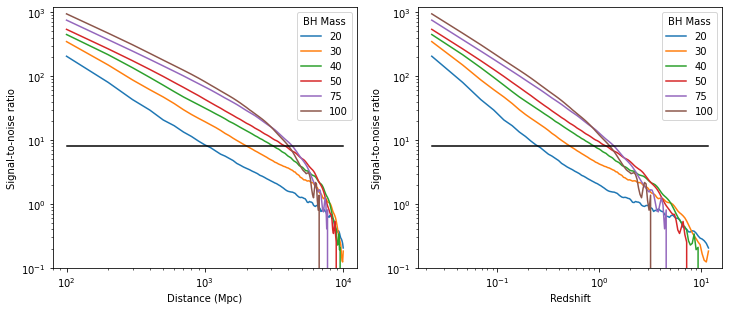

In [ ]:
fig = plt.figure()

plt.subplot(1,2,1)

for i in range(len(snrlist)):
  pylab.loglog(distances, snrlist[i])

x = [100, 10000]
y = [8, 8]
pylab.loglog(x, y, color="black")

pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-noise ratio")
pylab.ylim(0.1, 1200)
pylab.legend(labels=[20,30,40,50,75,100], title="BH Mass")

plt.subplot(1,2,2)

redshifts = [0] * len(distances)
for i in range(len(distances)):
  redshifts[i] = z_at_value(func=Planck18.comoving_distance, fval=distances[i] * u.Mpc)

for i in range(len(snrlist)):
    pylab.loglog(redshifts, snrlist[i])

x = [z_at_value(func=Planck18.comoving_distance, fval=100 * u.Mpc), z_at_value(func=Planck18.comoving_distance, fval=10000 * u.Mpc)]
pylab.loglog(x, y, color='black')

pylab.xlabel("Redshift")
pylab.ylabel("Signal-to-noise ratio")
pylab.ylim(0.1, 1200)
pylab.legend(labels=[20, 30, 40, 50, 75, 100], title='BH Mass')

fig.set_figheight(4.8)
fig.set_figwidth(12)

In [ ]:
## Effect of imprecise mass template waveforms at different distances

masses30 = np.arange(25, 35, 0.25)
masses40 = np.arange(35, 45, 0.25)
masses50 = np.arange(45, 55, 0.25)
masses75 = np.arange(70, 80, 0.25)
masses100 = np.arange(95, 105, 0.25)

snr30 = [0] * len(masses30)
snr40 = [0] * len(masses40)
snr50 = [0] * len(masses50)
snr75 = [0] * len(masses75)
snr100 = [0] * len(masses100)

templates = [masses30, masses40, masses50, masses75, masses100]
masses = [30, 40, 50, 75, 100]
snrlist = [snr30, snr40, snr50, snr75, snr100]

for d in range(len(masses30)):

  for i in range(len(snrlist)):

    snrlist[i][d] = expectation_SNR(mass1=masses[i], mass2=masses[i], templatemass1=templates[i][d], templatemass2=templates[i][d],
                                    resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20, distance=500,
                                    psd='aLIGODesignSensitivityP1200087', cosmology=Planck18)
    
    print("Mass {}, template {}".format(masses[i], templates[i][d]))

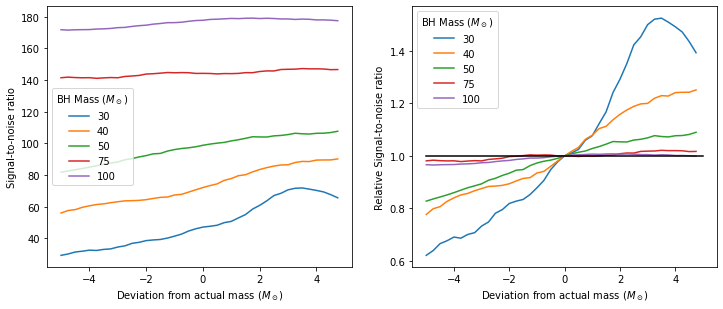

In [ ]:
deviation = np.arange(-5, 5, 0.25)

snr30rel = snr30 / snr30[20]
snr40rel = snr40 / snr40[20]
snr50rel = snr50 / snr50[20]
snr75rel = snr75 / snr75[20]
snr100rel = snr100 / snr100[20]

snrlistrel = [snr30rel, snr40rel, snr50rel, snr75rel, snr100rel]

fig = plt.figure()

plt.subplot(1,2,1)
for i in range(len(snrlist)):
  pylab.plot(deviation, snrlist[i])

pylab.xlabel("Deviation from actual mass ($M_\odot$)")
pylab.ylabel("Signal-to-noise ratio")
pylab.legend(labels = [30, 40, 50, 75, 100], title = "BH Mass ($M_\odot$)")

plt.subplot(1,2,2)
for i in range(len(snrlistrel)):
  pylab.plot(deviation, snrlistrel[i])

x = [-5, 5]
y = [1, 1]
pylab.plot(x, y, color = "black")

pylab.xlabel("Deviation from actual mass ($M_\odot$)")
pylab.ylabel("Relative Signal-to-noise ratio")
pylab.legend(labels = [30, 40, 50, 75, 100], title = "BH Mass ($M_\odot$)")

fig.set_figheight(4.8)
fig.set_figwidth(12)

In [ ]:
## Effect of imprecise mass template waveforms at different distances

masses50 = np.arange(40, 60, 0.25)

snr100 = [0] * len(masses50)
snr500 = [0] * len(masses50)
snr1000 = [0] * len(masses50)
snr3000 = [0] * len(masses50)

distances = [100, 500, 1000, 3000]
snrlist = [snr100, snr500, snr1000, snr3000]

for i in range(len(snrlist)):

  for m in range(len(masses50)):

    snrlist[i][m] = expectation_SNR(mass1=50, mass2=50, templatemass1=masses50[m], templatemass2=masses50[m],
                                    resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20,
                                    distance=distances[i], psd='aLIGODesignSensitivityP1200087')
    
    print("Distance {}, mass {}".format(distances[i], masses50[m]))


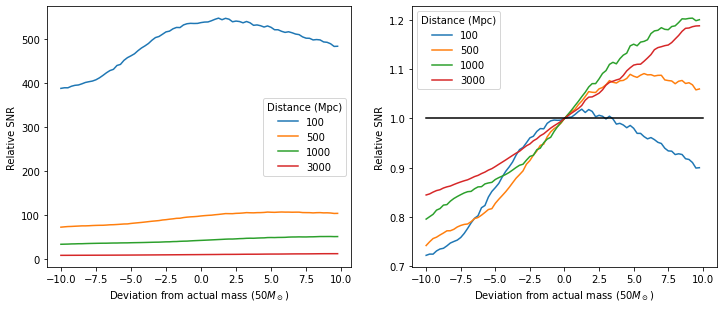

In [ ]:
deviation = np.arange(-10, 10, 0.25)

snr100rel = snr100 / snr100[40]
snr500rel = snr500 / snr500[40]
snr1000rel = snr1000 / snr1000[40]
snr3000rel = snr3000 / snr3000[40]

fig = plt.figure()

plt.subplot(1,2,1)
for i in range(len(snrlist)):
  pylab.plot(deviation, snrlist[i])

pylab.legend(labels = [100, 500, 1000, 3000], title="Distance (Mpc)")
pylab.ylabel("Relative SNR")
pylab.xlabel("Deviation from actual mass ($50 M_\odot$)")


plt.subplot(1,2,2)
snrlistrel = [snr100rel, snr500rel, snr1000rel, snr3000rel]

for i in range(len(snrlistrel)):
  pylab.plot(deviation, snrlistrel[i])

x = [-10, 10]
y = [1, 1]
pylab.plot(x, y, color = "black")

pylab.legend(labels = [100, 500, 1000, 3000], title="Distance (Mpc)")
pylab.ylabel("Relative SNR")
pylab.xlabel("Deviation from actual mass ($50 M_\odot$)")

fig.set_figheight(4.8)
fig.set_figwidth(12)

In [ ]:
## Effect of imprecise template waveforms varying both masses separately 
## Test different masses at different distances

snr30d500 = np.zeros((20,20))
snr30d1000 = np.zeros((20,20))
snr30d3000 = np.zeros((20,20))

snr50d500 = np.zeros((20,20))
snr50d1000 = np.zeros((20,20))
snr50d3000 = np.zeros((20,20))

snr75d500 = np.zeros((20,20))
snr75d1000 = np.zeros((20,20))
snr75d3000 = np.zeros((20,20))

masslist = [30, 50, 75]
distances = [500, 1000, 3000]

snr30 = [snr30d500, snr30d1000, snr30d3000]
snr50 = [snr50d500, snr50d1000, snr50d3000]
snr75 = [snr75d500, snr75d1000, snr75d3000]
snrlist = [snr30, snr50, snr75]

for i in range(len(masslist)):
  for d in range(len(distances)):

    for r in range(len(snr30d500)):
      for c in range(len(snr30d500[r])):

        templatemass1 = (masslist[i] - 5) + 0.5*r
        templatemass2 = (masslist[i] - 5) + 0.5*c

        snrlist[i][d][r][c] = expectation_SNR(mass1=masslist[i], mass2=masslist[i], templatemass1=templatemass1, templatemass2=templatemass2,
                                              resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20,
                                              distance=distances[d], psd='aLIGODesignSensitivityP1200087')
        
        print("Mass {}, Distance {}, Template1 {}, Template 2 {}".format(masslist[i], distances[d], templatemass1, templatemass2))


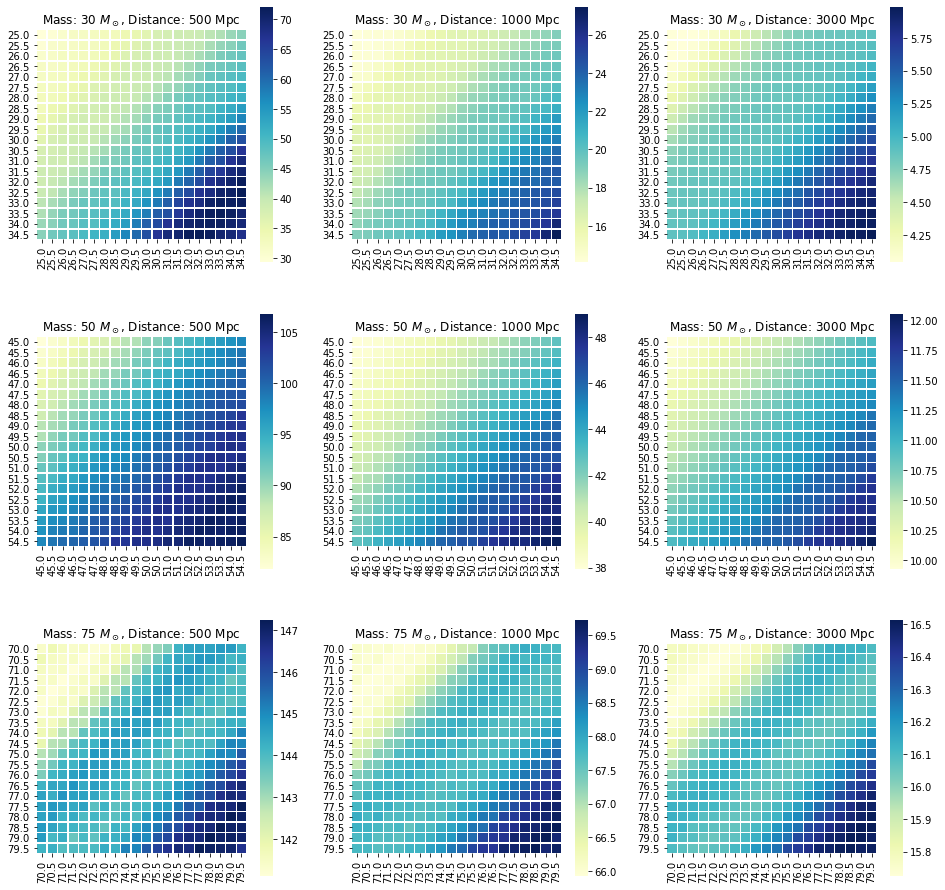

In [ ]:
fig = plt.figure(figsize = (16.0,16.0))

for i in range(len(snrlist)):
  for j in range(len(snr30)):

    names = np.arange((masslist[i]-5), (masslist[i]+5), 0.5)
    heatmap = pd.DataFrame(snrlist[i][j], columns=names, index=names)

    pos = fig.add_subplot(3,3, (3*i + j + 1))

    sns.heatmap(heatmap, ax=pos, linewidths=0.25, cmap="YlGnBu", square="True").set(title="Mass: {} $M_\odot$, Distance: {} Mpc".format(masslist[i], distances[j]))


(10, 2048.0)

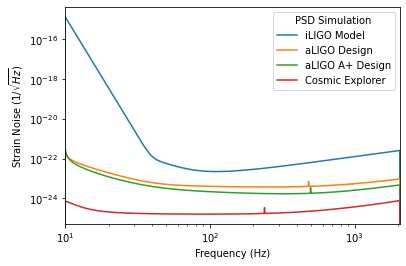

In [ ]:
## Effect of different sensitivites 
## Plot noise curves first 

flow = 10
delta_f = 1.0 / 16
flen = int(4096 / (2 * delta_f)) + 1

iligopsd = pycbc.psd.iLIGOModel(flen, delta_f, flow)
aligopsd = pycbc.psd.aLIGODesignSensitivityP1200087(flen, delta_f, flow)
apluspsd = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, delta_f, flow)
cosmicpsd = pycbc.psd.CosmicExplorerP1600143(flen, delta_f, flow)

pylab.loglog(iligopsd.sample_frequencies, np.sqrt(iligopsd))
pylab.loglog(aligopsd.sample_frequencies, np.sqrt(aligopsd))
pylab.loglog(apluspsd.sample_frequencies, np.sqrt(apluspsd))
pylab.loglog(cosmicpsd.sample_frequencies, np.sqrt(cosmicpsd))

pylab.xlabel("Frequency (Hz)")
pylab.ylabel("Strain Noise ($1/\sqrt{Hz}$)")
pylab.legend(labels = ["iLIGO Model", "aLIGO Design", "aLIGO A+ Design", "Cosmic Explorer"], title = "PSD Simulation")
pylab.xlim(flow, 4096/2)

In [ ]:
distances = np.arange(100, 10000, 100)

aligosnr = [0] * len(distances)
aplussnr = [0] * len(distances)
cosmicsnr = [0] * len(distances)

snrlist = [aligosnr, aplussnr, cosmicsnr]
model = ['aLIGODesignSensitivityP1200087', 'aLIGOAPlusDesignSensitivityT1800042', 'CosmicExplorerP1600143']

for i in range(len(snrlist)):
  
  for d in range(len(distances)): 

    snrlist[i][d] = expectation_SNR(mass1=30, mass2=30, templatemass1=30, templatemass2=30,
                                    resolution=1.0/1024, psdresolution=1.0/16, lowfreq=10, distance=distances[d],
                                    psd=model[i], cosmology=Planck18)
    
    print("Model: {}, Distance: {}".format(model[i], distances[d]))

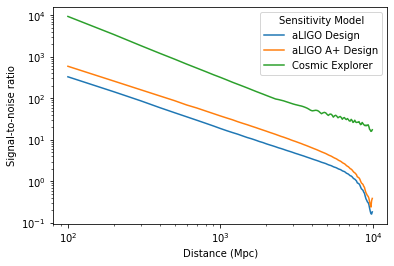

In [ ]:
for i in range(len(snrlist)):
  pylab.loglog(distances, snrlist[i])

pylab.xlabel("Distance (Mpc)")
pylab.ylabel("Signal-to-noise ratio")
pylab.legend(labels=["aLIGO Design", "aLIGO A+ Design", "Cosmic Explorer"], title="Sensitivity Model")

In [ ]:
## Effect of varying masses

totalmass = [40, 60, 80, 100, 150, 200]

ratio = np.arange(1, 10, 0.1)

snr20 = [0] * len(ratio)
snr30 = [0] * len(ratio)
snr40 = [0] * len(ratio)
snr50 = [0] * len(ratio)
snr75 = [0] * len(ratio)
snr100 = [0] * len(ratio)

snrlist = [snr20, snr30, snr40, snr50, snr75, snr100]

for i in range(len(snrlist)):

  for r in range(len(ratio)):

    mass1 = totalmass[i] / (ratio[r] + 1)
    mass2 = ratio[r] * mass1

    snrlist[i][r] = expectation_SNR(mass1=mass1, mass2=mass2, templatemass1=mass1, templatemass2=mass2,
                                    resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20, distance=500, 
                                    psd='aLIGODesignSensitivityP1200087', cosmology=Planck18)
    
    print("Mass: {}, Ratio: {}".format(totalmass[i], ratio[r]))

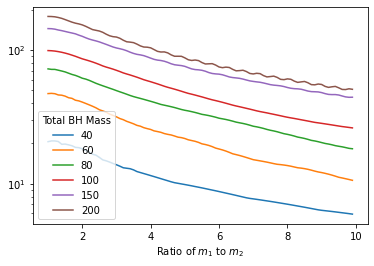

In [ ]:
for i in range(len(snrlist)):
  pylab.plot(ratio, snrlist[i])

pylab.yscale('log')
pylab.xlabel('Ratio of $m_1$ to $m_2$')
pylab.legend(labels = [40, 60, 80, 100, 150, 200], title = "Total BH Mass")

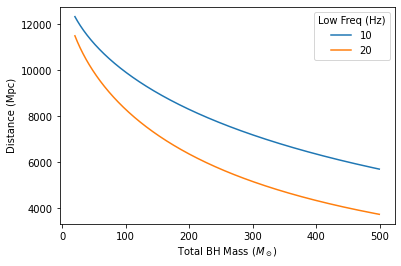

In [ ]:
## Plot maximum redshift distance

masses = np.arange(20, 500, 0.5)
maxrange10 = [0] * len(masses)
maxrange20 = [0] * len(masses) 

for i in range(len(masses)):
  period = np.sqrt(32) * math.pi * (6.67430 * 10**(-11)) * masses[i] * (1.98847 * 10**30) / (299792458)**3
  maxredshift10 = (1 / 10) / period
  maxredshift20 = (1 / 20) / period
  maxrange10[i] = Planck18.comoving_distance(maxredshift10).value
  maxrange20[i] = Planck18.comoving_distance(maxredshift20).value

pylab.plot(masses, maxrange10)
pylab.plot(masses, maxrange20)
pylab.xlabel("Total BH Mass ($M_\odot$)")
pylab.ylabel("Distance (Mpc)")
pylab.legend(labels = [10, 20], title = "Low Freq (Hz)")